In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
import math
# univariate bidirectional lstm
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

from sklearn.metrics import mean_squared_error

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
df=pd.read_csv("/content/drive/MyDrive/AI-HPA_Model/data/log_df_pods_slow.csv").drop(["Unnamed: 0"], axis=1)

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size, single_step=False):
    data=[]
    labels=[]
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        #Reshape data from (history_size,) to (history_size,1)
        data.append(np.reshape(dataset[indices], (history_size,1)))

        if single_step:
            labels.append(dataset[i+target_size])
        else:
            labels.append(dataset[i:i+target_size])
            
    return np.array(data), np.array(labels)

In [7]:
TRAIN_SPLIT = 2000000
tf.random.set_seed(13)

In [8]:
uni_data = df['pods']
uni_data.index = df.index
uni_data.head()

0     9
1     9
2     9
3    10
4    11
Name: pods, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f160c3a96d0>],
      dtype=object)

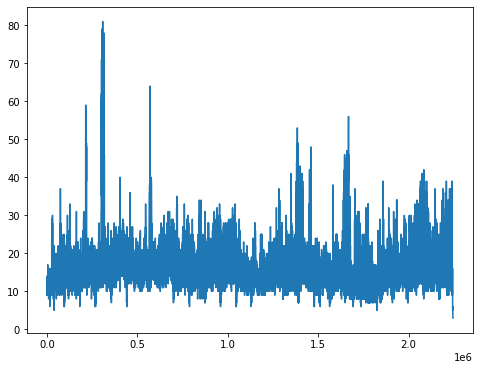

In [9]:
uni_data.plot(subplots=True)

In [10]:
uni_data = uni_data.values

In [11]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
univariate_past_history = 10
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target, single_step=True)

In [46]:
len(x_train_uni), len(x_val_uni)

(1999990, 245294)

In [47]:
print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[ 9]
 [ 9]
 [ 9]
 [10]
 [11]
 [11]
 [11]
 [11]
 [11]
 [11]]

 Target temperature to predict
[11]


In [48]:
def create_time_steps(length):
    return list(range(-length, 0))

In [49]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [50]:
BATCH_SIZE = 8
BUFFER_SIZE = 20

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [51]:
with tf.device('/device:GPU:0'):
  simple_lstm_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(100, return_sequences=True), input_shape=x_train_uni.shape[-2:]),
      Dense(128, activation='tanh'),
      Dense(64, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(50)),
      # Dense(128, activation='tanh'),
      # Dense(128, activation='tanh'),
      Dense(units=1),
  ])

  simple_lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])#tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
  simple_lstm_model.summary() 


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 10, 200)          81600     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 10, 128)           25728     
                                                                 
 dense_10 (Dense)            (None, 10, 64)            8256      
                                                                 
 bidirectional_9 (Bidirectio  (None, 100)              46000     
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 161,685
Trainable params: 161,685
Non-tr

In [52]:
EVALUATION_INTERVAL = 200 #데이터셋 크기가 큼으로 시간을 절약하기위해서 각 EPOCH는 200스탭만 실시합니다
EPOCHS = 200
model_path = 'model.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
hist=simple_lstm_model.fit(train_univariate, epochs=EPOCHS, validation_data=val_univariate, validation_steps=50, verbose=1, callbacks=callbacks, steps_per_epoch=EVALUATION_INTERVAL)

Epoch 1/200
200/200 [==============================] - 10s 18ms/step - loss: 1.8336 - rmse: 1.3541 - val_loss: 28.6556 - val_rmse: 5.3531
Epoch 2/200
200/200 [==============================] - 2s 11ms/step - loss: 0.4174 - rmse: 0.6460 - val_loss: 20.9502 - val_rmse: 4.5771
Epoch 3/200
200/200 [==============================] - 2s 11ms/step - loss: 0.4708 - rmse: 0.6862 - val_loss: 5.7998 - val_rmse: 2.4083
Epoch 4/200
200/200 [==============================] - 2s 12ms/step - loss: 0.4125 - rmse: 0.6422 - val_loss: 3.4013 - val_rmse: 1.8443
Epoch 5/200
200/200 [==============================] - 3s 17ms/step - loss: 0.4076 - rmse: 0.6384 - val_loss: 18.6749 - val_rmse: 4.3214
Epoch 6/200
200/200 [==============================] - 2s 12ms/step - loss: 4.6270 - rmse: 2.1510 - val_loss: 11.6854 - val_rmse: 3.4184
Epoch 7/200
200/200 [==============================] - 2s 12ms/step - loss: 0.3111 - rmse: 0.5578 - val_loss: 0.7567 - val_rmse: 0.8699
Epoch 8/200
200/200 [======================

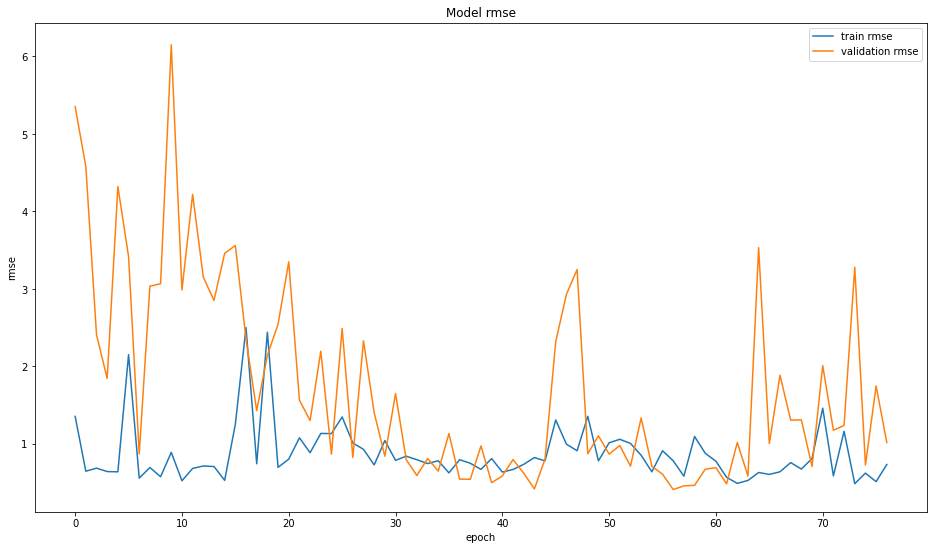

In [53]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['rmse'])
plt.plot(hist.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

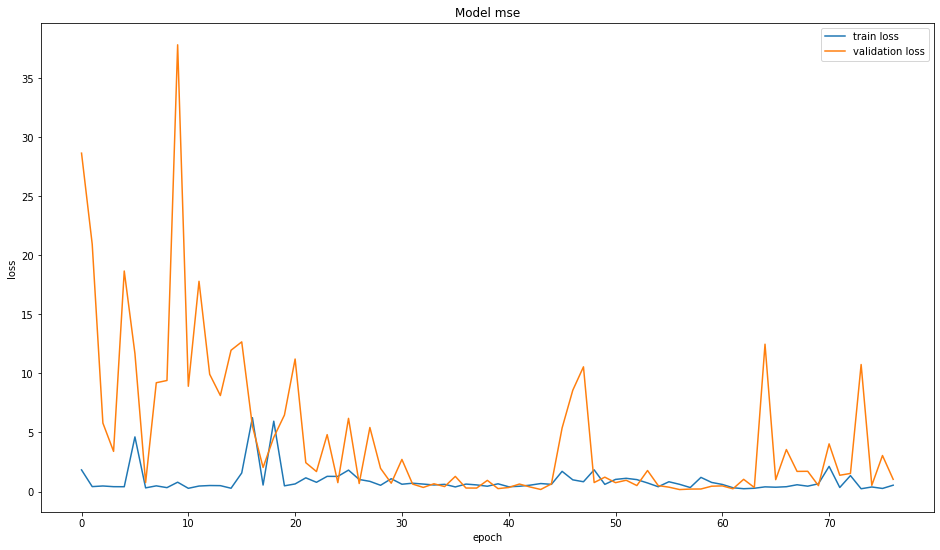

In [54]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

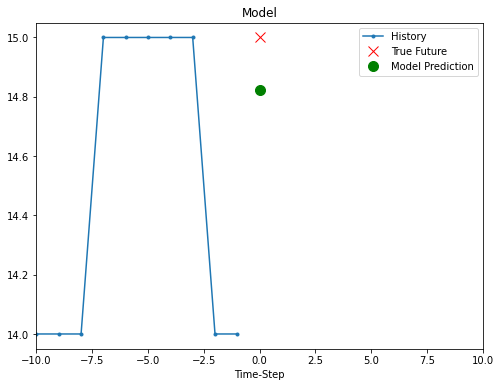

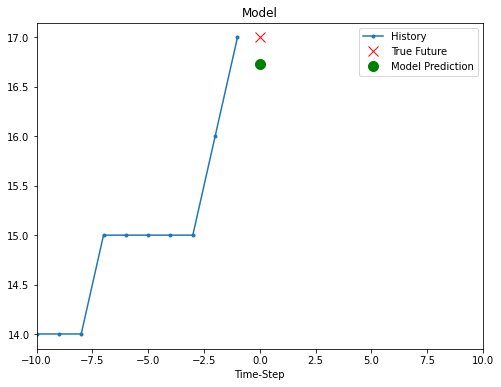

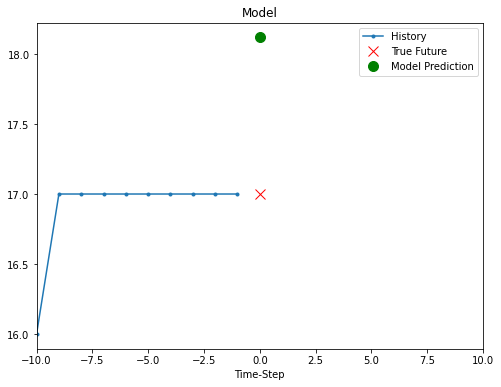

In [55]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Model')
    plot.show()

In [56]:
!pip install pyyaml h5py  # HDF5 포맷으로 모델을 저장하기 위해서 필요합니다!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.8.2


In [58]:
simple_lstm_model.save('/content/drive/MyDrive/AI-HPA_Model/data/bi_lstm_model1.pkl')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-HPA_Model/data/bi_lstm_model1.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-HPA_Model/data/bi_lstm_model1.pkl/assets


In [59]:
with tf.device('/device:GPU:0'):
  simple_lstm_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(100, return_sequences=True), input_shape=x_train_uni.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(50)),
      # Dense(128, activation='tanh'),
      # Dense(128, activation='tanh'),
      Dense(units=1),
  ])

  simple_lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])#tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
  simple_lstm_model.summary() 


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 10, 200)          81600     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 10, 128)           25728     
                                                                 
 bidirectional_11 (Bidirecti  (None, 100)              71600     
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 179,029
Trainable params: 179,029
Non-trainable params: 0
_________________________________________________________________


In [60]:
EVALUATION_INTERVAL = 200 #데이터셋 크기가 큼으로 시간을 절약하기위해서 각 EPOCH는 200스탭만 실시합니다
EPOCHS = 200
model_path = 'model.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
hist=simple_lstm_model.fit(train_univariate, epochs=EPOCHS, validation_data=val_univariate, validation_steps=50, verbose=1, callbacks=callbacks, steps_per_epoch=EVALUATION_INTERVAL)

Epoch 1/200
200/200 [==============================] - 16s 31ms/step - loss: 1.4657 - rmse: 1.2107 - val_loss: 26.4155 - val_rmse: 5.1396
Epoch 2/200
200/200 [==============================] - 4s 22ms/step - loss: 0.4552 - rmse: 0.6747 - val_loss: 22.1919 - val_rmse: 4.7108
Epoch 3/200
200/200 [==============================] - 4s 21ms/step - loss: 0.4731 - rmse: 0.6878 - val_loss: 5.7997 - val_rmse: 2.4083
Epoch 4/200
200/200 [==============================] - 5s 23ms/step - loss: 0.4442 - rmse: 0.6665 - val_loss: 2.9834 - val_rmse: 1.7272
Epoch 5/200
200/200 [==============================] - 4s 22ms/step - loss: 0.3815 - rmse: 0.6177 - val_loss: 16.5808 - val_rmse: 4.0719
Epoch 6/200
200/200 [==============================] - 4s 21ms/step - loss: 0.4311 - rmse: 0.6565 - val_loss: 10.2285 - val_rmse: 3.1982
Epoch 7/200
200/200 [==============================] - 4s 19ms/step - loss: 0.3111 - rmse: 0.5578 - val_loss: 0.5369 - val_rmse: 0.7327
Epoch 8/200
200/200 [======================

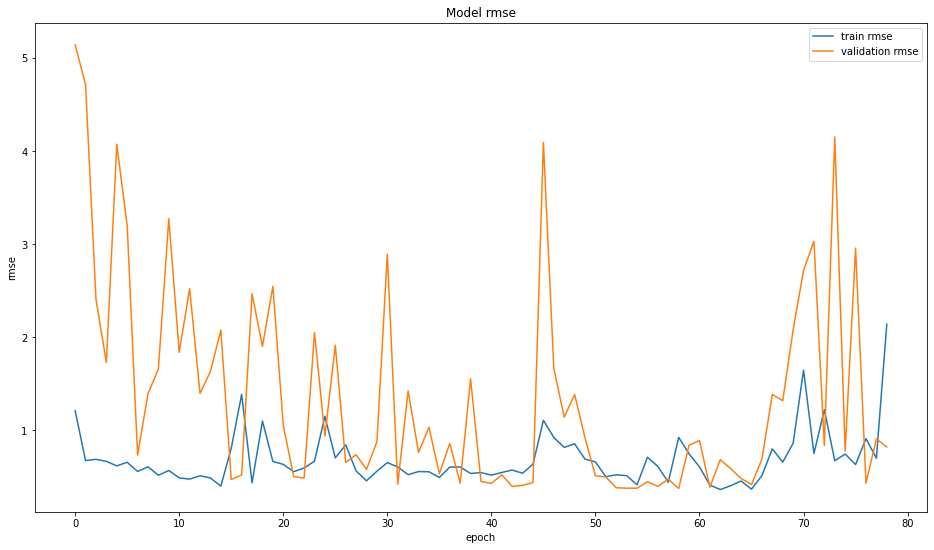

In [61]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['rmse'])
plt.plot(hist.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

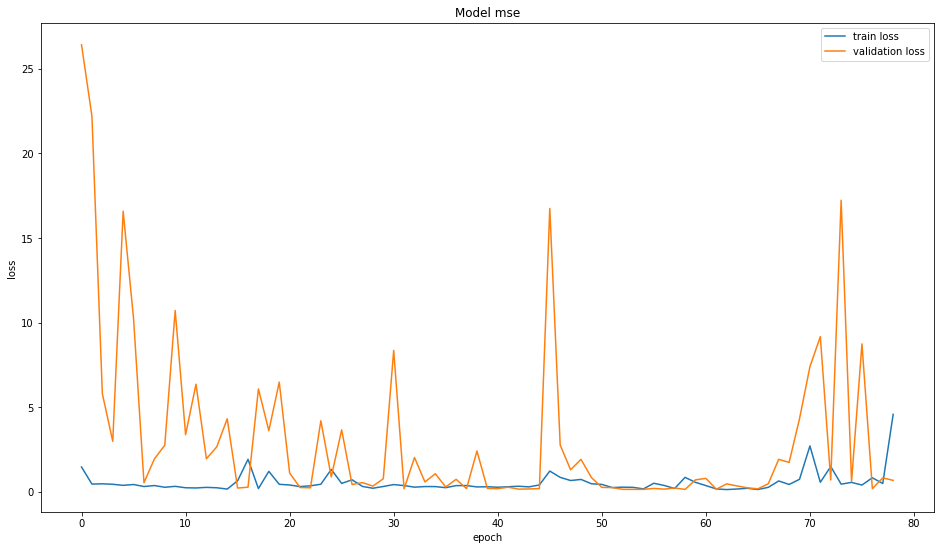

In [62]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

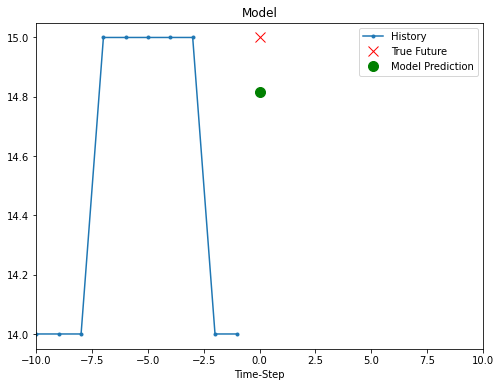

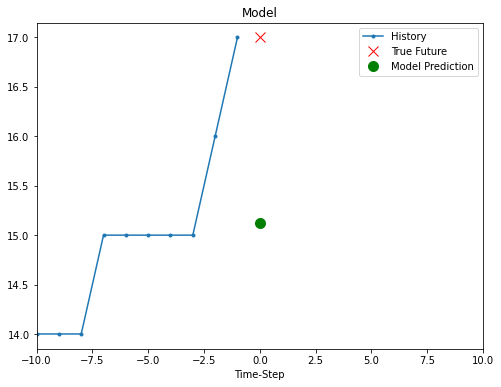

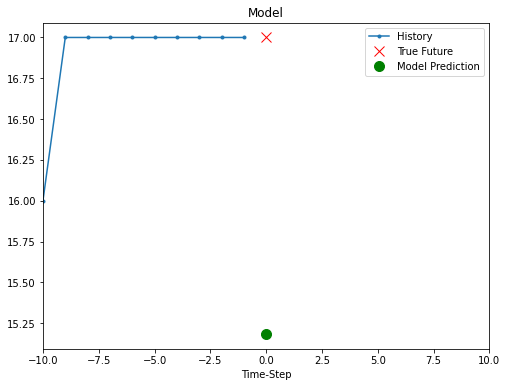

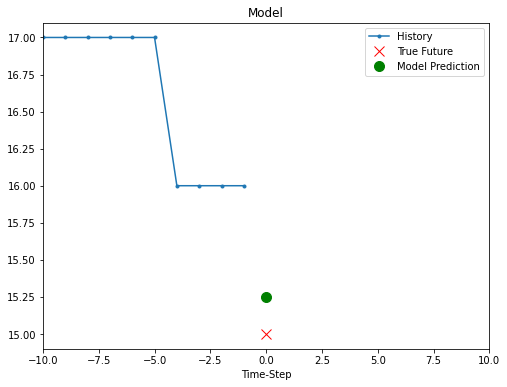

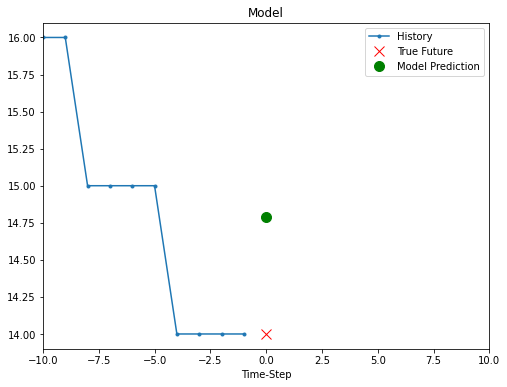

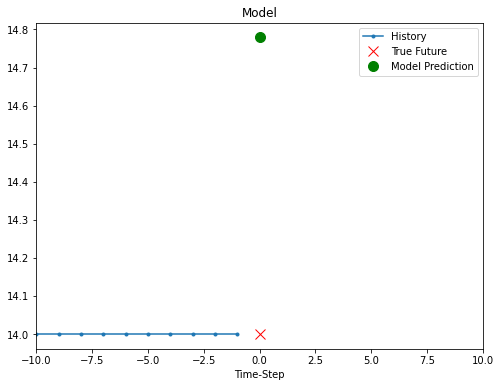

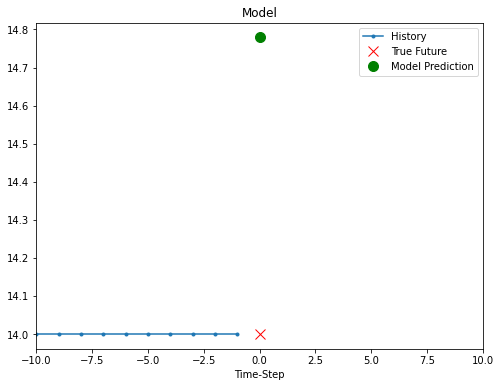

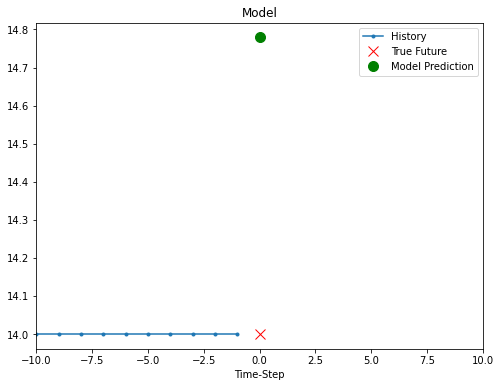

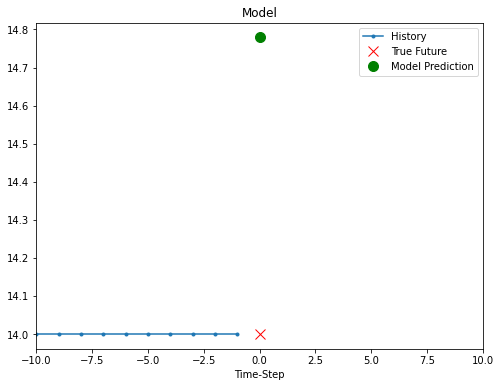

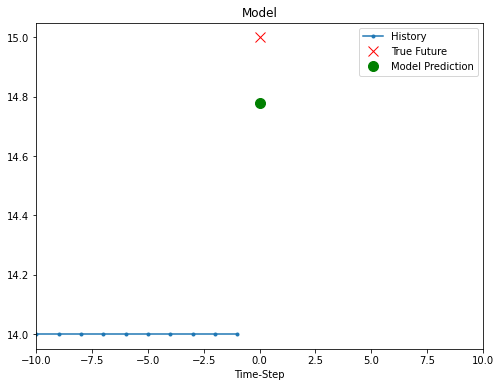

In [63]:
for x, y in val_univariate.take(10):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Model')
    plot.show()

In [64]:
simple_lstm_model.save('/content/drive/MyDrive/AI-HPA_Model/data/bi_lstm_model0.pkl')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-HPA_Model/data/bi_lstm_model0.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-HPA_Model/data/bi_lstm_model0.pkl/assets


# Test

In [67]:
from keras.models import load_model

model=load_model('/content/drive/MyDrive/AI-HPA_Model/data/bi_lstm_model0.pkl')

In [73]:
yhat=model.predict(x_val_uni[0])
yhat[0], y_val_uni[0]

(array([15.890847], dtype=float32), 15)